In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

df_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/gender_prediction/data/uic_blogs_gender/train_bert.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/gender_prediction/data/uic_blogs_gender/test_bert.csv')

df_train

,post,gender
0,"Galicia (Part 2)\nFebruary 28, 2010\nBecause ...",1
1,I like to think of this theater as the Coloss...,1
2,Power of Sattva...Unleashed in Mumbai 23 to ...,0
3,"Back during the 2008 presidential campaign, th...",0
4,Britain's small businesses are being offered f...,0
...,...,...
2575,The rain eased off and a glowing purple and re...,0
2576,While I am giving the finishing touches at Lin...,0
2577,The Trauma of Restlessness.... Its 1 am midnig...,0
2578,If you compare vision research with NLP resear...,0


Note that male is encoded as 0, and female as 1

In [3]:
df_test

,post,gender
0,Saint Patrick's Day! I totally forgot. That is...,0
1,If NP Bayes had its way on this problem (or at...,0
2,"Okay, so this list is all food. But frankly, w...",0
3,Sair para comer a dois é uma aventura que eu ...,0
4,Parents are probably the most interesting and ...,1
...,...,...
641,"Dear Mom,\n\nMental illness runs in our family...",1
642,"I traded in my 2003 Ultra Classic (42,000 mile...",0
643,"Recently, spm resultt released. Those people a...",1
644,So this photo has finally run in Vogue Girl K...,0


In [4]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 2.6 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
     |████████████████████████████████| 6.5 MB 44.7 MB/s 
     |████████████████████████████████| 895 kB 56.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Using the following tutorial: https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import EarlyStoppingCallback

In [6]:
# Define pretrained tokenizer and model

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name, do_lower_case=True)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
#                                                            output_attentions = True,
#                                                            output_hidden_states = True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

### 1. Preprocess data

In [7]:
X = list(df_train['post'])
y = list(df_train['gender'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=df_train['gender'], random_state=0)

In [8]:
X_train_tokenized = tokenizer(
    X_train, 
    add_special_tokens = True,    # add [CLS], [SEP]
    max_length = 512,             # max length of the text that can go to BERT
    truncation = True,            # cut off the input sequences that are longer than max_length 
    padding = True,               # add [PAD] tokens to pad to the longest sequence
    return_attention_mask = True, # add attention mask to not focus on pad tokens
    return_tensors='pt'           # return tensors for pytorch (not tensforflow)
    )

X_val_tokenized = tokenizer(
    X_val,    
    add_special_tokens = True,    # add [CLS], [SEP]
    max_length = 512,             # max length of the text that can go to BERT
    truncation = True,            # cut off the input sequences that are longer than max_length 
    padding = True,               # add [PAD] tokens to pad to the longest sequence
    return_attention_mask = True, # add attention mask to not focus on pad tokens
    return_tensors='pt'           # return tensors for pytorch (not tensforflow)
    )

In [9]:
# Create torch dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

### 2. Fine-tune pretrained model

In [10]:
# use GPU if there's a GPU available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Using the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU.')
    device = torch.device("cpu")

model.to(device)

No GPU available, using the CPU.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [11]:
# Define Trainer parameters

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [15]:
# Define Trainer

# for parameters, see here: https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments
args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API",
    weight_decay=0.01,   # I think weights decay reduces risk of overfitting??
    learning_rate=1e-5,  # defaults to 5e-5
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    seed=0,
    warmup_steps=200, 
    evaluation_strategy="steps",
    save_steps=150,
    #load_best_model_at_end=True,
    logging_steps=150,
    logging_first_step=True,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/logs',
    overwrite_output_dir=False
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

using `logging_steps` to initialize `eval_steps` to 150
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# Train pre-trained model

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2064
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1290
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
150,0.684300,0.653839,0.649225,0.652968,0.576613,0.612420
300,0.616500,0.568185,0.703488,0.689243,0.697581,0.693387
450,0.549100,0.574490,0.713178,0.656250,0.846774,0.739437
600,0.497800,0.536180,0.751938,0.747934,0.729839,0.738776


***** Running Evaluation *****
  Num examples = 516
  Batch size = 20
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-150
Configuration saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-150/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-150/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 516
  Batch size = 20
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/hugg

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
150,0.684300,0.653839,0.649225,0.652968,0.576613,0.612420
300,0.616500,0.568185,0.703488,0.689243,0.697581,0.693387
450,0.549100,0.574490,0.713178,0.656250,0.846774,0.739437
600,0.497800,0.536180,0.751938,0.747934,0.729839,0.738776
750,0.440000,0.523540,0.763566,0.769231,0.725806,0.746888


***** Running Evaluation *****
  Num examples = 516
  Batch size = 20
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750
Configuration saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 516
  Batch size = 20


In [16]:
trainer.train(resume_from_checkpoint = True)

Loading model from /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2064
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1290
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 750
  Will skip the first 2 epochs then the first 234 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your 

  0%|          | 0/234 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
900,0.369100,0.560450,0.740310,0.733607,0.721774,0.727642
1050,0.332800,0.573660,0.751938,0.725564,0.778226,0.750973
1200,0.272200,0.587353,0.736434,0.720472,0.737903,0.729084


***** Running Evaluation *****
  Num examples = 516
  Batch size = 20
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-900
Configuration saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-900/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-900/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 516
  Batch size = 20
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/hugg

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
900,0.369100,0.560450,0.740310,0.733607,0.721774,0.727642
1050,0.332800,0.573660,0.751938,0.725564,0.778226,0.750973
1200,0.272200,0.587353,0.736434,0.720472,0.737903,0.729084




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1290, training_loss=0.12995406897493111, metrics={'train_runtime': 13540.4738, 'train_samples_per_second': 0.762, 'train_steps_per_second': 0.095, 'total_flos': 1367063554129920.0, 'train_loss': 0.12995406897493111, 'epoch': 5.0})

In [19]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290'
trainer.save_model(model_dir)

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290
Configuration saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290/pytorch_model.bin


### 3. Evaluate on test set

In [18]:
# Tokenize test data
X_test = list(df_test['post'])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512) 

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

### Try models of the different checkpoints

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

checkpoints = [150, 300, 450, 600, 750, 900, 1050, 1200, 1290]
accuracies = []
f1 = []

for cp in checkpoints:
  # Load trained model
  model_path = "/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-" + str(cp)
  model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2) 

  # Define test trainer
  test_trainer = Trainer(model)

  # Make prediction
  raw_pred, _, _ = test_trainer.predict(test_dataset) 

  # Preprocess raw predictions
  y_pred = np.argmax(raw_pred, axis=1)
  y_true = df_test['gender']

  print("\nModel performance after " + str(cp) + " steps:")
  print("Accuracy = " + str(accuracy_score(y_true, y_pred)))
  print("F1 score = " + str(f1_score(y_true, y_pred, average='weighted')) + "\n")

  accuracies.append(accuracy_score(y_true, y_pred))
  f1.append(f1_score(y_true, y_pred, average='weighted'))

loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-150/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-150/pytorch_model.bin
All model checkpoint weights were used whe

loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-300/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-300/pytorch_model.bin



 Model performance after 150 steps:
Accuracy = 0.6718266253869969
F1 score = 0.669375765105611



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-300.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-450/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-450/pytorch_model.bin



 Model performance after 300 steps:
Accuracy = 0.7058823529411765
F1 score = 0.7059162293318728



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-450.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-600/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-600/pytorch_model.bin



 Model performance after 450 steps:
Accuracy = 0.6965944272445821
F1 score = 0.6939976430686372



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-600.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750/pytorch_model.bin



 Model performance after 600 steps:
Accuracy = 0.7198142414860681
F1 score = 0.7195400825097678



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-750.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-900/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-900/pytorch_model.bin



 Model performance after 750 steps:
Accuracy = 0.718266253869969
F1 score = 0.7180224575414108



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-900.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1050/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1050/pytorch_model.bin



 Model performance after 900 steps:
Accuracy = 0.7074303405572755
F1 score = 0.7074113784177825



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1050.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1200/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1200/pytorch_model.bin



 Model performance after 1050 steps:
Accuracy = 0.6965944272445821
F1 score = 0.6967107815829604



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1200.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8


loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290/pytorch_model.bin



 Model performance after 1200 steps:
Accuracy = 0.7012383900928792
F1 score = 0.7013336888520202



All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-1290.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 646
  Batch size = 8



 Model performance after 1290 steps:
Accuracy = 0.6996904024767802
F1 score = 0.6997767645159453



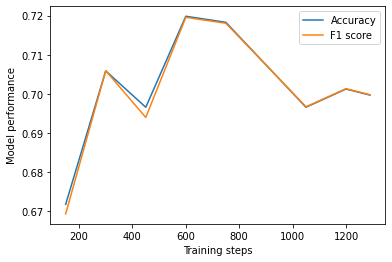

In [38]:
import matplotlib.pyplot as plt

plt.plot(checkpoints, accuracies, label="Accuracy")
plt.plot(checkpoints, f1, label="F1 score")
plt.xlabel('Training steps')
plt.ylabel('Model performance')
plt.legend()
plt.show()

-> best model seems to be after 600 steps or 750 steps, then it decreased

In [31]:
# Load trained model
model_path = "/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-600"
model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2) 

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset) 

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_true = df_test['gender']

loading configuration file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-600/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/checkpoint-600/pytorch_model.bin
All model checkpoint weights were used whe

In [34]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 score: " + str(f1_score(y_true, y_pred, average='weighted')))

Accuracy: 0.7198142414860681
F1 score: 0.7195400825097678


In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       336
           1       0.72      0.69      0.70       310

    accuracy                           0.72       646
   macro avg       0.72      0.72      0.72       646
weighted avg       0.72      0.72      0.72       646



In [33]:
# Save the best model
model_dir = '/content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/best-model'
test_trainer.save_model(model_dir)

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/best-model
Configuration saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/best-model/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/gender_prediction/models/uic_blogs_gender/bert/huggingface-API/best-model/pytorch_model.bin
